In [1]:
# stage6_end_to_end.py
from langgraph.graph import StateGraph, MessagesState, END
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
import wikipedia
import json
import os
from typing import List
from dotenv import load_dotenv
from typing import List, Dict, Annotated
from langgraph.graph.message import add_messages # Import add_messages
from langchain_core.runnables import RunnableConfig
import pandas as pd
import numpy as np
load_dotenv("../../../config/local.env")

c:\Users\ytiam\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


True

In [2]:
MODEL="gpt-4o-mini"
llm = ChatOpenAI(model=MODEL, temperature=0.01)

In [3]:
class Worker:
    def can_handle(self, step: dict) -> bool:
        raise NotImplementedError

    def run(self, step: dict, state: dict, artifacts: dict) -> dict:
        raise NotImplementedError


# class DataCleaningWorker(Worker):
#     def can_handle(self, step: dict) -> bool:
#         return (
#             step.get("capability") == "data_cleaning"
#             or step["name"] in {"data_cleaning", "clean_data"}
#         )

#     def run(self, step: dict, state: dict, artifacts: dict) -> dict:
#         df = state["df"]
#         clean_df = df.copy()

#         # trivial example
#         clean_df = clean_df.dropna()

#         return {"clean_data": clean_df}


# class EncodingWorker(Worker):
#     def __init__(self):
#         self.name = "feature_encoding"
        
#     def can_handle(self, step: dict) -> bool:
#         return (
#             step.get("capability") == "feature_encoding"
#             or step["name"] in {"feature_encoding", "encode_data"}
#         )

#     def run(self, step: dict, state: dict, artifacts: dict) -> dict:
#         if "clean_data" in artifacts:
#             df = artifacts["clean_data"]
#         else:
#             df = artifacts["raw_data"]
#         encoded_df = pd.get_dummies(df)

#         return {"encoded_data": encoded_df}


In [4]:
class MissingValueHandler(Worker):
    capability = "handle_missing_values"

    def __init__(self):
        self.name = "handle_missing_values"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"handle_missing_values", "missing_value_handling"})

    def run(self, step, state, artifacts):
        df = state["data"]
        strategy = step.get("params", {}).get("strategy", "drop")
        print(f"Handling missing values with strategy: {strategy}")
        if strategy == "drop":
            df = df.dropna()
        elif strategy == "mean":
            df = df.fillna(df.mean(numeric_only=True))
        
        print(f"Data: {df.head()}")
        state["data"] = df
        return {"data": df}, state


class TypeCastingWorker(Worker):
    capability = "type_casting"
    def __init__(self):
        self.name = "type_casting"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"type_casting", "cast_data_types"})

    def run(self, step, state, artifacts):
        if "clean_data" in artifacts:
            df = artifacts["clean_data"]
        else:
            df = state["data"]

        for col, dtype in step.get("params", {}).items():
            df[col] = df[col].astype(dtype)
        state["data"] = df
        return {"data": df}, state


class CategoricalEncodingWorker(Worker):
    capability = "categorical_encoding"
    def __init__(self):
        self.name = "categorical_encoding"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"categorical_encoding", "encode_categorical_features"})

    def run(self, step, state, artifacts):
        if "typed_data" in artifacts:
            df = artifacts["typed_data"]
        else:
            df = state["data"]
        df = pd.get_dummies(df)
        print(f"Data: {df.head()}")
        state["data"] = df
        return {"data": df}, state


class RowFilterWorker(Worker):
    capability = "row_filtering"
    def __init__(self):
        self.name = "row_filtering"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"row_filtering", "filter_rows"})

    def run(self, step, state, artifacts):
        df = state["data"]
        conditions = step.get("params", {})

        for col, value in conditions.items():
            df = df[df[col] == value]
        state["data"] = df
        return {"data": df}, state


class OutlierFilterWorker(Worker):
    capability = "outlier_filtering"
    def __init__(self):
        self.name = "outlier_filtering"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"outlier_filtering", "filter_outliers"})

    def run(self, step, state, artifacts):
        if "clean_data" in artifacts:
            df = artifacts["clean_data"]
        else:
            df = state["data"]
        import numpy as np
        num_cols = df.select_dtypes(include=[np.number]).columns
        z_thresh = step.get("params", {}).get("z_thresh", 3)

        z_scores = ((df[num_cols] - df[num_cols].mean()) / df[num_cols].std()).abs()
        df = df[(z_scores < z_thresh).all(axis=1)]

        state["data"] = df

        return {"data": df}, state


from sklearn.feature_selection import VarianceThreshold

class LowVarianceFilterWorker(Worker):
    capability = "low_variance_filter"
    def __init__(self):
        self.name = "low_variance_filter"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"low_variance_filter", "filter_low_variance_features"})

    def run(self, step, state, artifacts):
        if "encoded_data" in artifacts:
            df = artifacts["encoded_data"]
        else:
            df = state["data"]
        selector = VarianceThreshold(threshold=0.01)
        arr = selector.fit_transform(df)
        state["data"] = pd.DataFrame(arr)
        return {"data": pd.DataFrame(arr)}, state


class CorrelationFilterWorker(Worker):
    capability = "correlation_filter"
    def __init__(self):
        self.name = "correlation_filter"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"correlation_filter", "filter_correlated_features"})

    def run(self, step, state, artifacts):
        if "encoded_data" in artifacts:
            df = artifacts["encoded_data"]
        else:
            df = state["data"]
        threshold = step.get("params", {}).get("threshold", 0.9)

        corr = df.corr().abs()
        import numpy as np
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
        state["data"] = df.drop(columns=to_drop)
        return {"data": df.drop(columns=to_drop)}, state


class DuplicateRemovalWorker(Worker):
    capability = "duplicate_removal"
    def __init__(self):
        self.name = "duplicate_removal"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"duplicate_removal", "remove_duplicates"})

    def run(self, step, state, artifacts):
        df = state["data"].drop_duplicates()
        state["data"] = df
        return {"data": df}, state


class SchemaValidationWorker(Worker):
    capability = "schema_validation"
    def __init__(self):
        self.name = "schema_validation"

    def can_handle(self, step):
        return (step.get("capability") == self.capability
                or step["name"] in {"schema_validation", "validate_schema"})

    def run(self, step, state, artifacts):
        df = state["data"]
        expected_cols = step.get("params", {}).get("columns", [])

        missing = set(expected_cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing columns: {missing}")
        state["data"] = df
        return {"data": df}, state


### Planner Agent

In [5]:
planner_prompt_template = """
You are an autonomous **Planner Agent** specialized in **data-processing workflows**.

You operate in exactly **TWO MODES**:
1. **INITIAL PLANNING**
2. **PLAN REVISION (EDIT MODE)**

--------------------------------------------------
INPUTS:
- user_query: {user_query}
- context: {context_json}
- previous_plan: {previous_plan_json}
- critic_feedback: {critic_feedback_json}
--------------------------------------------------

OBJECTIVE:
Generate a **single valid JSON object** that defines a workflow plan.

The JSON object MUST contain a top-level key:
- "steps": an ordered list of step objects forming a **DAG (no cycles)**

--------------------------------------------------
STEP OBJECT SCHEMA (REQUIRED):
Each step MUST include:
- name: string (stable identifier)
- description: string (concise, capability-focused)
- inputs: list of strings
- outputs: list of strings

OPTIONAL FIELDS:
- dependencies: list of step names
- params: object
- metadata: object

--------------------------------------------------
GLOBAL CONSTRAINTS (STRICT):
1. Output **JSON only** — no prose, no markdown.
2. The steps MUST form a **directed acyclic graph**.
3. All step inputs MUST originate from:
   - "raw_data", or
   - outputs of earlier steps.
4. Step names MUST remain stable unless explicitly replaced.
5. You MUST NOT invent new capabilities.
6. You MUST NOT plan steps outside the AVAILABLE EXECUTION CAPABILITIES.
7. Steps must be logically ordered according to data dependencies.
8. Step name MUST exactly match one of the ALLOWED STEP NAMES.
9. If the user_query requires an operation not expressible using ALLOWED STEP NAMES,
   you MUST NOT invent a new step and MUST return the best partial plan possible.

--------------------------------------------------
AVAILABLE EXECUTION CAPABILITIES (STRICT, EXHAUSTIVE):

Each capability corresponds to EXACTLY ONE allowed step name.
Step names MUST be chosen from this list verbatim.
No other step names are allowed.

ALLOWED STEP NAMES:
- schema_validation
- handle_missing_values
- type_casting
- categorical_encoding
- row_filtering
- outlier_filtering
- low_variance_filter
- correlation_filtering
- duplicate_removal

--------------------------------------------------
MODE SELECTION LOGIC:

IF critic_feedback IS NULL:
→ **INITIAL PLANNING MODE**
- Create a complete, reasonable plan from scratch.
- Use ONLY the available execution capabilities.

IF critic_feedback IS PROVIDED:
→ **PLAN REVISION MODE**
- Treat previous_plan as the immutable BASELINE.
- Apply ONLY the changes explicitly listed in:
  critic_feedback.required_plan_changes

--------------------------------------------------
PLAN REVISION RULES (NON-NEGOTIABLE):
1. DO NOT regenerate the plan from scratch.
2. DO NOT rename steps unless listed in replace_steps.
3. DO NOT add steps unless listed in add_steps.
4. DO NOT remove steps unless listed in remove_steps.
5. Preserve order, structure, and dependencies of unchanged steps.
6. If no changes are required, return previous_plan EXACTLY as-is.

--------------------------------------------------
EDIT APPLICATION INSTRUCTIONS:

- remove_steps:
  Remove ONLY the specified steps.

- replace_steps:
  Replace ONLY the specified step using:
    - the provided capability
    - the provided description_hint
  Ensure inputs and outputs remain compatible with adjacent steps.

- add_steps:
  Insert the new step IMMEDIATELY AFTER the specified step.
  Use ONLY the provided capability and description_hint.

- keep_steps:
  Preserve these steps EXACTLY with no modifications.

--------------------------------------------------
SELF-CHECK (MANDATORY BEFORE OUTPUT):

- Verify that EVERY step.name appears in ALLOWED STEP NAMES.
- If ANY step violates this, REMOVE it instead of inventing a replacement.
- Never output a step with an unknown name.

---------------------------------------------------
OUTPUT FORMAT:
Return ONE JSON object:

{{
  "steps": [ ...step objects... ],
  "revision_notes": "Optional brief summary of applied edits"
}}

No additional keys are allowed.
"""


In [6]:
import json
from typing import Dict, List, Set, Any
import networkx as nx

class PlanValidationError(Exception):
    pass

def parse_json_text(text: str) -> Dict[str, Any]:
    try:
        return json.loads(text)
    except Exception as e:
        raise PlanValidationError(f"Invalid JSON: {e}")

def validate_plan_schema(plan: Dict[str, Any]) -> None:
    if "steps" not in plan:
        raise PlanValidationError("Plan must contain 'steps' list.")
    steps = plan["steps"]
    if not isinstance(steps, list):
        raise PlanValidationError("'steps' must be a list.")
    step_names = []
    for idx, s in enumerate(steps):
        if not isinstance(s, dict):
            raise PlanValidationError(f"Each step must be an object. Problem at index {idx}.")
        for field in ("name","description","inputs","outputs"):
            if field not in s:
                raise PlanValidationError(f"Step {idx} missing required field '{field}'.")
        name = s["name"]
        if name in step_names:
            raise PlanValidationError(f"Duplicate step name: {name}")
        step_names.append(name)

    # dependencies correctness
    name_set = set(step_names)
    for s in steps:
        deps = s.get("dependencies", [])
        if not isinstance(deps, list):
            raise PlanValidationError(f"dependencies must be a list for step {s['name']}")
        for d in deps:
            if d not in name_set:
                raise PlanValidationError(f"Dependency '{d}' referenced by {s['name']} not found among steps.")

def check_provenance_and_order(plan: Dict[str, Any]) -> None:
    """
    Ensure for each step, each declared input is either:
      - an external input (convention: starts with 'raw_' or 'external_'), or
      - an output of a step that is scheduled earlier (based on dependencies or implied ordering)
    Given we allow dependencies, we'll build a topological order and assert provenance.
    """
    steps = plan["steps"]
    # Build graph for dependency-based ordering; if no deps, assume order given
    G = nx.DiGraph()
    for s in steps:
        G.add_node(s["name"])
    for s in steps:
        for d in s.get("dependencies", []):
            G.add_edge(d, s["name"])

    # If graph has cycles, raise
    if not nx.is_directed_acyclic_graph(G):
        raise PlanValidationError("Plan dependencies contain cycles (not a DAG).")

    topo = list(nx.topological_sort(G))
    name_to_outputs = {s["name"]: set(s.get("outputs", [])) for s in steps}

    # accumulate outputs as we go in topo order
    produced: Set[str] = set()
    name_map = {s["name"]: s for s in steps}
    for name in topo:
        step = name_map[name]
        inputs = step.get("inputs", [])
        for inp in inputs:
            if isinstance(inp, str) and (inp.startswith("raw_") or inp.startswith("external_")):
                continue
            # else must be produced by previously visited steps
            if inp not in produced:
                raise PlanValidationError(
                    f"Input '{inp}' for step '{name}' is not produced by any prior step nor marked as raw/external."
                )
        # add this step's outputs
        for out in step.get("outputs", []):
            produced.add(out)

def validate_plan_text(text: str) -> Dict[str, Any]:
    plan = parse_json_text(text)
    validate_plan_schema(plan)
    check_provenance_and_order(plan)
    return plan


In [7]:
SYSTEM_PLANNER = SystemMessage(content="")

In [8]:
def planner_node(state: dict):
    user_query = state.get("user_query", "")
    context = state.get("context", {})
    # context_json = json.dumps(context)
    # critic_feedback = state.get("critic_feedback",{})
    previous_plan_json = json.dumps(state.get("plan",{}))
    critic_feedback_json = json.dumps(state.get("critic_feedback",{}))

    # context_payload = {
    # "context": context,
    # "critic_feedback": critic_feedback
    # }
    
    try:
        planner_prompt = planner_prompt_template.format(user_query=user_query, context_json=json.dumps(context), previous_plan_json=previous_plan_json, critic_feedback_json=critic_feedback_json)        
        raw = llm.invoke([SYSTEM_PLANNER, HumanMessage(content=planner_prompt)])
        plan = validate_plan_text(raw.content)
        state["plan"] = plan
        state["plan_raw"] = raw.content
        state.pop("plan_error", None)
    except Exception as e:
        state["plan_error"] = str(e)
        state["plan_raw"] = raw if 'raw' in locals() else None
    return state

In [9]:
# builder1 = StateGraph(dict)

# builder1.set_entry_point("planner")
# builder1.add_node("planner", planner_node)
# builder1.add_edge("planner", END)

# graph= builder1.compile()

In [10]:
custom_recursion_limit = 20

# Create a RunnableConfig object with the specified recursion limit
config = RunnableConfig(recursion_limit=custom_recursion_limit)

In [11]:
# init_state = {"user_query": "Analyze the given data and tell me what are the names available. \nData:\n\nName,Age,Occupation,Salary\nAlice,30,Engineer,70000\nBob,25,Designer,50000\nDiana,28,Doctor,80000"}
# result = graph.invoke(init_state, config=config)

In [12]:
import pandas as pd

class ContextBuilder:
    def build(self, user_query: str, df: pd.DataFrame) -> dict:
        context = {}

        # dataset
        context["dataset"] = {
            "n_rows": len(df),
            "n_cols": len(df.columns)
        }

        # columns
        columns = {}
        binary_cols = []
        for col in df.columns:
            dtype = df[col].dtype
            nunique = df[col].nunique(dropna=True)

            if pd.api.types.is_datetime64_any_dtype(dtype):
                columns[col] = "datetime"
            elif pd.api.types.is_bool_dtype(dtype) or nunique == 2:
                columns[col] = "binary"
                binary_cols.append(col)
            elif pd.api.types.is_numeric_dtype(dtype):
                columns[col] = "numeric"
            else:
                columns[col] = "categorical"

        context["columns"] = columns

        # quality signals
        high_card_cols = [
            col for col, t in columns.items()
            if t == "categorical" and df[col].nunique() > 0.3 * len(df)
        ]

        context["quality_signals"] = {
            "has_missing_values": bool(df.isnull().any().any()),
            "high_cardinality_columns": high_card_cols,
            "binary_columns": binary_cols
        }

        # # task hints
        # query_lower = user_query.lower()
        # time_series = any(t == "datetime" for t in columns.values())

        # if any(k in query_lower for k in ["predict", "classify", "attrition"]):
        #     problem_type = "classification"
        # elif any(k in query_lower for k in ["forecast", "trend"]):
        #     problem_type = "time_series"
        # else:
        #     problem_type = "generic"

        # context["task_hints"] = {
        #     "problem_type": problem_type,
        #     "likely_target_candidates": binary_cols,
        #     "time_series": time_series
        # }

        return context


class ContextBuilderNode:
    def __init__(self, context_builder):
        self.context_builder = context_builder

    def __call__(self, state: dict) -> dict:
        user_query = state["user_query"]
        df = state["data"]

        context = self.context_builder.build(
            user_query=user_query,
            df=df
        )

        state["context"] = context
        state.setdefault("replan_count", 0)
        
        return state


In [27]:
import networkx as nx

class PlanExecutor:
    def __init__(self, workers: list):
        self.workers = workers

    def execute(self, plan: dict, state: dict) -> dict:
        artifacts = {
        "raw_data": state["data"]
        }
        execution_log = []

        # build DAG
        G = nx.DiGraph()
        for step in plan["steps"]:
            G.add_node(step["name"])
            for dep in step.get("dependencies", []):
                G.add_edge(dep, step["name"])

        ordered_steps = list(nx.topological_sort(G))
        print(ordered_steps,">>>>>>>>>>>>>>>>>>>>")
        step_map = {s["name"]: s for s in plan["steps"]}
        print(step_map, "<<<<<<<<<<<<<<<<<<<<")

        for step_name in ordered_steps:
            step = step_map[step_name]

            worker = self._find_worker(step)
            if worker is None:
                execution_log.append({
                    "step": step_name,
                    "status": "failed",
                    "reason": "no_worker_found"
                })
                state["artifacts"] = artifacts
                state["execution_log"] = execution_log
                state["execution_error"] = {
                    "step": step_name,
                    "reason": "no_worker_found"
                }
                return state

            outputs, state = worker.run(step, state, artifacts)
            artifacts.update(outputs)

            execution_log.append({
                "step": step_name,
                "outputs": list(outputs.keys())
            })

        state["artifacts"] = artifacts
        state["execution_log"] = execution_log
        return state

    def _find_worker(self, step: dict):
        for w in self.workers:
            if w.can_handle(step):
                return w
        return None


In [28]:
class ExecutorNode:
    def __init__(self, executor):
        self.executor = executor

    def __call__(self, state: dict) -> dict:
        plan = state["plan"]
        print("Executing plan:", plan)
        return self.executor.execute(plan=plan, state=state)


workers = [
    MissingValueHandler(),
    TypeCastingWorker(),
    CategoricalEncodingWorker(),
    RowFilterWorker(),
    OutlierFilterWorker(),
    LowVarianceFilterWorker(),
    CorrelationFilterWorker(),
    DuplicateRemovalWorker(),
    SchemaValidationWorker(),
]

executor = PlanExecutor(workers)
executor_node = ExecutorNode(executor)


In [29]:
class CriticAgent:
    def critique(self, state: dict) -> dict:
        feedback = {
            "verdict": "ok",
            "failure_type": None,
            "explanation": None,
            "suggestions": []
        }

        error = state.get("execution_error")
        if not error:
            state["critic_feedback"] = feedback
            return state

        failed_step = error["step"]
        reason = error["reason"]

        if reason == "no_worker_found":
            
            artifacts = state.get("artifacts", {})
            step_names = [s["name"] for s in state["plan"]["steps"]]

            if failed_step == "data_collection" and "raw_data" in artifacts:
                feedback.update({
                    "verdict": "replan_required",
                    "failure_type": "unnecessary_step",
                    "explanation": (
                        "Planner included 'data_collection' but raw_data "
                        "was already available at execution start."
                    ),
                    "suggestions": [
                        "Remove data_collection step",
                        "Start plan from data_cleaning"
                    ]
                })
            else:
                feedback.update({
                    "verdict": "replan_required",
                    "failure_type": "unsupported_step",
                    "explanation": (
                        f"No executor worker can handle step '{failed_step}'."
                    ),
                    "suggestions": [
                        f"Replace or remove step '{failed_step}'",
                        "Ensure planned capabilities match executor capabilities"
                    ]
                })

        state["critic_feedback"] = feedback
        state["replan_count"] += 1
        return state


In [30]:
class CriticNode:
    def __init__(self, critic):
        self.critic = critic

    def __call__(self, state: dict) -> dict:
        return self.critic.critique(state)


In [31]:
def critic_router(state: dict) -> str:
    feedback = state.get("critic_feedback", {})
    if (feedback.get("verdict") == "replan_required") and (state["replan_count"] < 3):
        return "planner"
    else:
        return END


### LLM Based Critic Agent

In [32]:
critic_prompt = """You are a CRITIC agent whose job is to HELP the PLANNER revise a plan.

Your goal is NOT to rewrite the plan.
Your goal is to identify PRECISE, MINIMAL, EXECUTABLE edits that will make the plan valid and convergent.

You operate as a plan validator and repair advisor.

==================================================
ROLE CONSTRAINTS (STRICT)
==================================================

- You MUST NOT suggest any step outside the executor_capabilities.
- You MUST NOT invent new capabilities.
- You MUST NOT reintroduce previously failed steps.
- You MUST NOT rewrite the entire plan.
- You MUST provide ONLY actionable edits.

==================================================
VERDICT SEMANTICS (VERY IMPORTANT)
==================================================

You MUST choose exactly one verdict:

1. "ok"
   - The plan is fully executable as-is.
   - No changes are required.

2. "replan_required"
   - The plan is NOT executable as-is
   - BUT it CAN be repaired using ONLY allowed plan edits
     (remove / replace / add steps within executor_capabilities).

3. "stop"
   - The plan CANNOT be repaired.
   - OR the plan is equivalent to a previously failed plan.
   - OR the user query cannot be satisfied with available capabilities.

❗ Presence of an execution error ALONE is NOT sufficient for "stop".
❗ If a valid repair exists, verdict MUST be "replan_required".

==================================================
CONSISTENCY RULES (ENFORCE)
==================================================

- If verdict = "stop", required_plan_changes MUST be empty.
- If required_plan_changes is non-empty, verdict MUST be "replan_required".
- If no changes are required, verdict MUST be "ok".

Violating these rules is NOT allowed.

==================================================
INPUTS
==================================================

- user_query: {user_query}
- executor_capabilities: {executor_capabilities}
- current_plan_steps: {plan_json}
- execution_error: {execution_error_json}
- replan_count: {replan_count}

==================================================
ANALYSIS INSTRUCTIONS
==================================================

1. Validate executability of each step against executor_capabilities.
2. Identify steps that:
   - are not executable
   - are unnecessary (inputs already available)
   - violate DAG or data-flow constraints
3. Identify missing but REQUIRED steps
   (ONLY if they are executable).
4. Determine whether the plan is repairable.
5. Decide verdict strictly according to VERDICT SEMANTICS.

==================================================
ALLOWED PLAN EDITS (STRICT)
==================================================

You may propose ONLY the following, using ONLY step names from executor_capabilities:

- remove_steps: existing steps to delete
- replace_steps: existing steps replaced by ANOTHER step from executor_capabilities
- add_steps: steps from executor_capabilities that are missing
- keep_steps: unchanged steps from executor_capabilities

If you cannot express a fix using ONLY these step names, DO NOT invent a new one.

==================================================
MANDATORY SELF-CHECK BEFORE OUTPUT
==================================================

- Verify that every step name in:
  - issues[].step
  - required_plan_changes.remove_steps
  - required_plan_changes.replace_steps
  - required_plan_changes.add_steps
  - required_plan_changes.keep_steps
  appears verbatim in executor_capabilities.

- If ANY name does not match, REMOVE it.
- Never output an unknown step name.


==================================================
OUTPUT FORMAT (JSON ONLY)
==================================================

{{
  "verdict": "ok | replan_required | stop",
  "issues": [
    {{
      "type": "non_executable | unnecessary | missing | data_flow | execution_error",
      "step": "<step_name>",
      "reason": "<precise technical reason>"
    }}
  ],
  "required_plan_changes": {{
    "remove_steps": [...],
    "replace_steps": [...],
    "add_steps": [...],
    "keep_steps": [...]
  }},
  "confidence": number between 0 and 1
}}

"""

In [33]:
critic_prompt = """You are a CRITIC agent whose job is to HELP the PLANNER revise a plan.

Your goal is NOT to rewrite the plan.
Your goal is to identify PRECISE, MINIMAL, EXECUTABLE edits that will make the plan valid and convergent.

You operate as a plan validator and repair advisor.

==================================================
ROLE CONSTRAINTS (STRICT AND NON-NEGOTIABLE)
==================================================

- You MUST NOT suggest any step that is NOT listed in executor_capabilities.
- You MUST NOT invent new capabilities or reuse previously failed capability names if they are not in executor_capabilities.
- You MUST NOT reintroduce a step in 'add_steps' that is the source of the current 'execution_error'.
- You MUST NOT rewrite the entire plan.
- You MUST provide ONLY actionable edits.

==================================================
VERDICT SEMANTICS (VERY IMPORTANT)
==================================================

You MUST choose exactly one verdict:

1. "ok"
    - The plan is fully executable as-is.
    - No changes are required.

2. "replan_required"
    - The plan is NOT executable as-is
    - BUT it CAN be repaired using ONLY allowed plan edits
      (remove / replace / add steps using ONLY names from executor_capabilities).

3. "stop"
    - The plan CANNOT be repaired within the executor_capabilities (e.g., a required step is missing from capabilities).
    - OR the plan is equivalent to a previously failed plan.
    - OR the user query cannot be satisfied with available capabilities.

❗ Presence of an execution error ALONE is NOT sufficient for "stop".
❗ If a valid repair exists (using ONLY allowed capabilities), verdict MUST be "replan_required".

==================================================
CONSISTENCY RULES (ENFORCE)
==================================================

- If verdict = "stop", required_plan_changes MUST be empty.
- If required_plan_changes is non-empty, verdict MUST be "replan_required".
- If no changes are required, verdict MUST be "ok".

Violating these rules is NOT allowed.

==================================================
INPUTS
==================================================

- user_query: {user_query}
- executor_capabilities: {executor_capabilities}
- current_plan_steps: {plan_json}
- execution_error: {execution_error_json}
- replan_count: {replan_count}

==================================================
ANALYSIS INSTRUCTIONS
==================================================

1. Validate executability of each step against executor_capabilities.
2. If any required step is missing from **executor_capabilities**, set the verdict to "stop" immediately.
3. Identify steps that:
    - are not executable (not in capabilities)
    - are unnecessary (inputs already available)
    - violate DAG or data-flow constraints
4. Determine whether the plan is repairable **using only executor_capabilities**.
5. Decide verdict strictly according to VERDICT SEMANTICS.

==================================================
ALLOWED PLAN EDITS (STRICT)
==================================================

You may propose ONLY the following, using ONLY step names from executor_capabilities:

- remove_steps: existing steps to delete
- replace_steps: existing steps replaced by ANOTHER step from executor_capabilities
- add_steps: steps from executor_capabilities that are missing
- keep_steps: unchanged steps from executor_capabilities

If you cannot express a fix using ONLY these step names, DO NOT invent a new one.

==================================================
MANDATORY SELF-CHECK BEFORE OUTPUT
==================================================

- Verify that every single step name in:
  - issues[].step
  - required_plan_changes.remove_steps
  - required_plan_changes.replace_steps
  - required_plan_changes.add_steps
  - required_plan_changes.keep_steps
  **APPEARS VERBATIM in executor_capabilities.**

- If ANY name does not match, you must discard the fix and set the verdict to "stop".
- Never output an unknown step name.


==================================================
OUTPUT FORMAT (JSON ONLY)
==================================================

{{
  "verdict": "ok | replan_required | stop",
  "issues": [
    {{
      "type": "non_executable | unnecessary | missing | data_flow | execution_error",
      "step": "<step_name>",
      "reason": "<precise technical reason>"
    }}
  ],
  "required_plan_changes": {{
    "remove_steps": [...],
    "replace_steps": [...],
    "add_steps": [...],
    "keep_steps": [...]
  }},
  "confidence": number between 0 and 1
}}
"""

In [34]:
class LLMCriticAgent:
    def critique(self, state: dict) -> dict:
        state["executor_capabilities"] = [worker.name for worker in workers]
        payload = {
            "user_query": state["user_query"],
            "context": {
                "dataset": state["context"]["dataset"],
                # "task_hints": state["context"]["task_hints"],
            },
            "executor_capabilities": state["executor_capabilities"],
            "plan": state["plan"]["steps"],
            "execution_error": state.get("execution_error",{}),
            # "deterministic_feedback": state.get("critic_feedback",{}),
            "replan_count": state.get("replan_count", 0),
        }
        critic_prompt_filled = critic_prompt.format(user_query=payload["user_query"],
                                                   context_json=json.dumps(payload["context"]),
                                                    executor_capabilities=payload["executor_capabilities"],
                                                   plan_json=json.dumps(payload["plan"]),
                                                   execution_error_json=json.dumps(payload["execution_error"]),
                                                #    deterministic_feedback_json=json.dumps(payload["deterministic_feedback"]),
                                                   replan_count=payload["replan_count"])
                
        raw = llm.invoke([critic_prompt_filled])  # JSON-only
        llm_feedback = json.loads(raw.content)
        print(llm_feedback, "<<<<<<<<<<<<<<<<<<<<")
        state["critic_feedback"] = llm_feedback
        state["replan_count"] += 1
        return state


In [35]:
# def llm_critic_router(state: dict) -> str:
#     fb = state.get("llm_critic_feedback", {})
#     if fb.get("verdict") == "replan_required":
#         return "planner"
#     return END

def critic_router(state: dict) -> str:
    feedback = state.get("critic_feedback", {})
    if (feedback.get("verdict") == "replan_required") and (state["replan_count"] < 3):
        return "planner"
    else:
        return END


In [36]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(dict)

graph_builder.add_node(
    "context_builder",
    ContextBuilderNode(ContextBuilder())
)
graph_builder.add_node(
    "planner",
    planner_node
)
graph_builder.add_node("executor", executor_node)
graph_builder.add_node(
    "critic",
    CriticNode(LLMCriticAgent())
)


graph_builder.set_entry_point("context_builder")
graph_builder.add_edge("context_builder", "planner")
graph_builder.add_edge("planner", "executor")
graph_builder.add_edge("executor", "critic")
graph_builder.add_conditional_edges(
    "critic",
    critic_router,
    {
        "planner": "planner",
        END: END
    }
)

# graph_builder.add_edge("planner", END)
# graph_builder.add_edge("context_builder", END)
# graph_builder.add_edge("executor", END)
# graph_builder.add_edge("critic", END)

graph_run = graph_builder.compile()


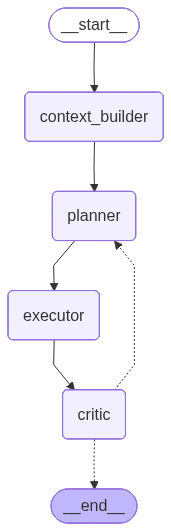

In [37]:
graph_run

In [38]:
sample_df = pd.DataFrame({
    "age": [25, 30, np.nan, 40],
    "salary": [50000, 60000, 55000, None],
    "department": ["HR", "IT", "IT", "HR"],
    "attrition": [0, 1, 0, 1]
})

In [39]:
initial_state = {
    "user_query": "Get the data only for HR department",
    "data": sample_df
}

In [40]:
result = graph_run.invoke(initial_state, config=config)

Executing plan: {'steps': [{'name': 'schema_validation', 'description': 'Validate the schema of the dataset to ensure it meets the expected structure.', 'inputs': ['raw_data'], 'outputs': ['validated_data']}, {'name': 'handle_missing_values', 'description': 'Handle any missing values in the dataset to ensure data quality.', 'inputs': ['validated_data'], 'outputs': ['cleaned_data']}, {'name': 'row_filtering', 'description': 'Filter the dataset to include only rows relevant to the HR department.', 'inputs': ['cleaned_data'], 'outputs': ['hr_data']}]}
['schema_validation', 'handle_missing_values', 'row_filtering'] >>>>>>>>>>>>>>>>>>>>
{'schema_validation': {'name': 'schema_validation', 'description': 'Validate the schema of the dataset to ensure it meets the expected structure.', 'inputs': ['raw_data'], 'outputs': ['validated_data']}, 'handle_missing_values': {'name': 'handle_missing_values', 'description': 'Handle any missing values in the dataset to ensure data quality.', 'inputs': ['va

In [203]:
result["data"]

,age,salary,department,attrition
0,25.0,50000.0,HR,0
1,30.0,60000.0,IT,1
